# MPS using the deesse wrapper - simulations with probability constraints

## Main points addressed:
- deesse simulation with probability (proportion) constraints: 
    - categorical or continuous variable
    - local or global probability constraints
    
**Note:** if *global* probability constraints are used and if deesse is launched in parallel (with more than one thread), the reproducibility is not guaranteed.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi

## 1. Categorical simulations - global probability constraints

### Training image (TI)
Read the training image. (Source of the image: *D. Allard, D. D'or, and R. Froidevaux, An efficient maximum entropy approach for categorical variable prediction, EUROPEAN JOURNAL OF SOIL SCIENCE, 62(3):381-393, JUN 2011, doi: 10.1111/j.1365-2389.2011.01362.x*)

In [2]:
ti = img.readImageGslib('ti2.gslib')

Plot the image (using the function `imgplt.drawImage2D`).

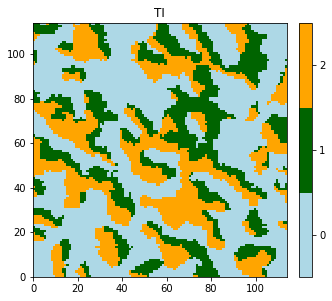

In [3]:
col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, categ=True, categCol=col, title='TI')

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [4]:
nx, ny, nz = 300, 300, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Define the classes of values
Set the number of classes, and for each class define the ensemble of values as a (union of) interval(s).

In [5]:
nclass = 3
class1 = [-0.5, 0.5] # interval [-0.5, 0.5[ (for facies code 0)
class2 = [ 0.5, 1.5] # interval [ 0.5, 1.5[ (for facies code 1)
class3 = [ 1.5, 2.5] # interval [ 1.5, 2.5[ (for facies code 2)
# classx = [[-0.5, 0.5],[ 1.5, 2.5]] # for the union [-0.5, 0.5[ U [1.5, 2.5[, containing facies codes 0 and 2
list_of_classes = [class1, class2, class3]

### Define probability constraints (class `dsi.SoftProbability`)
To save time and to avoid noisy simulations, probability constraints can be deactivated when the last pattern node (the farest away from the central cell) is at a distance less than a given value (`deactivationDistance`). Note that the distance is computed according to the units defined for the search neighborhood ellipsoid.

In [6]:
sp = dsi.SoftProbability(
    probabilityConstraintUsage=1,   # global probability constraints
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    globalPdf=[0.2, 0.5, 0.3],      # global target PDF (list of length nclass)
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(dsi.SoftProbability))
    deactivationDistance=4.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=1.e-3)        # acceptation threshold

### Fill the input structure for deesse and launch deesse
Deesse is launched with one thread (`nthreads=1`) to ensure reproducibility when global probability constraints are used.

In [7]:
nreal = 1
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='categ',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType=0,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input, nthreads=1)

********************************************************************************
DEESSE VERSION 3.1 / BUILD NUMBER 20190307
********************************************************************************
DONE


### Retrieve the results (and display)

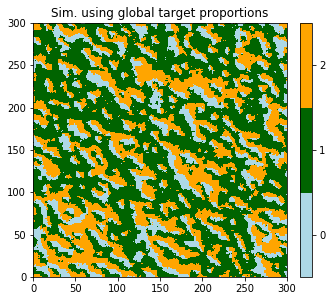

In [8]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
imgplt.drawImage2D(sim[0], categ=True, categCol=col,
                   title='Sim. using global target proportions')

### Compare facies proportions (TI, simulation, target)

In [9]:
ti.get_prop()

[[0.0, 1.0, 2.0], array([[0.51492767, 0.23114805, 0.25392428]])]

In [10]:
sim[0].get_prop() # target proportions are: [0.2, 0.5, 0.3]

[[0.0, 1.0, 2.0], array([[0.1911    , 0.51236667, 0.29653333]])]

## 2. Categorical simulations - local probability constraints

Target proportions can be specified locally. For each cell, target proportions (for each class) in a region around the cell is considered. Hence, proportion maps are required as well as a support radius: the region is defined as the ensemble of the cells in the search neighborhood ellipsoid and at a distance to the central (simulated) cell inferior or equal to the given support radius. Note that the distance are computed according to the units defined for the search neighborhood ellipsoid.

### Build local target proportions maps

In [11]:
# xg, yg: coordinates of the centers of grid cell
xg = ox + 0.5*sx + sx*np.arange(nx)
yg = oy + 0.5*sy + sy*np.arange(ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define proportion maps for each class
c = 0.6
p1 = xx + yy     
p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
p2 = c - p1
p0 = 1.0 - p1 - p2 # constant map (1-c = 0.4)

local_pdf = np.zeros((nclass, nz, ny, nx))
local_pdf[0,0,:,:] = p0
local_pdf[1,0,:,:] = p1
local_pdf[2,0,:,:] = p2

Plot these maps.

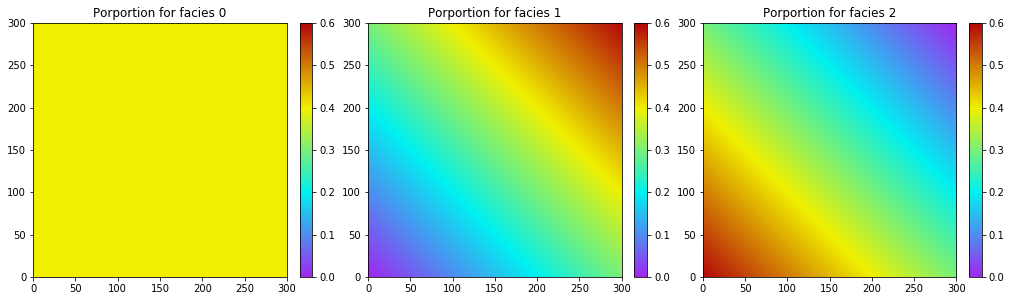

In [12]:
im = img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=3, v=local_pdf)

plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
plt.subplot(1,3,1)
imgplt.drawImage2D(im, iv=0, vmin=0, vmax=c, title='Porportion for facies 0')
plt.subplot(1,3,2)
imgplt.drawImage2D(im, iv=1, vmin=0, vmax=c, title='Porportion for facies 1')
plt.subplot(1,3,3)
imgplt.drawImage2D(im, iv=2, vmin=0, vmax=c, title='Porportion for facies 2')


### Define probability constraints (class `dsi.SoftProbability`)

In [13]:
sp = dsi.SoftProbability(
    probabilityConstraintUsage=2,   # local probability constraints
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    localPdfSupportRadius=12.,      # support radius
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(dsi.SoftProbability))
    deactivationDistance=4.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=1.e-3)        # acceptation threshold

### Fill the input structure for deesse and launch deesse

In [14]:
nreal = 1
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='categ',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType=0,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

********************************************************************************
DEESSE VERSION 3.1 / BUILD NUMBER 20190307
********************************************************************************
DONE


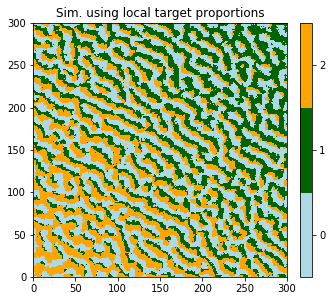

In [15]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
imgplt.drawImage2D(sim[0], categ=True, categCol=col,
                   title='Sim. using local target proportions')

## 3. Continuous simulation - global probability constraints

### Training image (TI)
(Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006, doi: 10.1007/s11004-005-9004-x*)

In [16]:
ti = img.readImageGslib('tiContinuous.gslib')

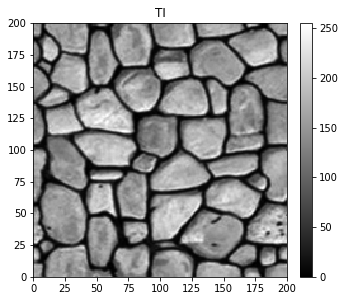

In [17]:
plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, cmap=ccol.cmapB2W, title='TI')

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [18]:
nx, ny, nz = 200, 200, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Define the classes of values
Set the number of classes, and for each class define the ensemble of values as a (union of) interval(s).

In [19]:
vmin, vmax = 0., 256.
nclass = 10
breaks = np.linspace(vmin, vmax, nclass+1)
list_of_classes = [np.array([[breaks[i], breaks[i+1]]]) for i in range(nclass)]

### Define probability constraints (class `dsi.SoftProbability`)

In [20]:
global_pdf = np.repeat(1./nclass, nclass) # global pdf (proportion for each class), uniform

sp = dsi.SoftProbability(
    probabilityConstraintUsage=1,   # global probability constraints
    nclass=nclass,                       # number of classes of values
    classInterval=list_of_classes,  # list of classes
    globalPdf=global_pdf,           # global target PDF (list of length nclass)
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(dsi.SoftProbability))
    deactivationDistance=2.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=0)            # acceptation threshold

### Fill the input structure for deesse and launch deesse
Deesse is launched with one thread (`nthreads=1`) to ensure reproducibility when global probability constraints are used.

In [21]:
nreal = 1
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType=1,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.5,
    npostProcessingPathMax=0, # disable post-processing (to avoid losing target proportions)
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input, nthreads=1)

********************************************************************************
DEESSE VERSION 3.1 / BUILD NUMBER 20190307
********************************************************************************
DONE


Text(0.5,1,'Proportions of values on the classes')

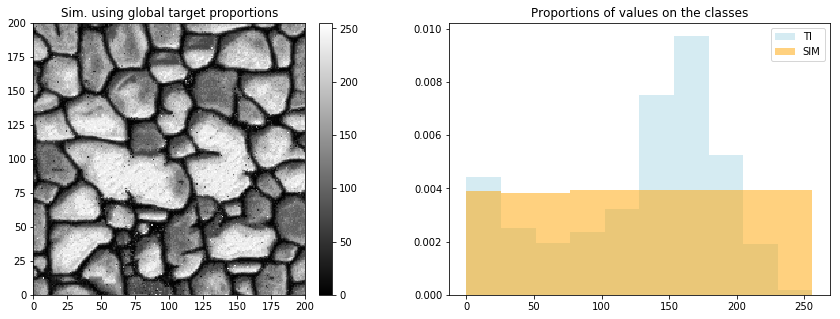

In [22]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.subplots(1,2, figsize=(15,5)) # 1 x 2 sub-plots

plt.subplot(1,2,1)
imgplt.drawImage2D(sim[0], cmap=ccol.cmapB2W,
                   title='Sim. using global target proportions')

plt.subplot(1,2,2)
plt.hist(ti.val.reshape(-1), bins=breaks, density=True, color='lightblue', alpha=0.5, label='TI')
plt.hist(sim[0].val.reshape(-1), bins=breaks, density=True, color='orange', alpha=0.5, label='SIM')
plt.legend()
plt.title('Proportions of values on the classes')

## 4. Continuous simulations - local probability constraints

### Define new classes of values

In [23]:
nclass = 2
class1 = [0., 50.]   # interval [0., 50.[ (low values)
class2 = [50., 256.] # interval [50., 256.[ (high values)
list_of_classes = [class1, class2]

### Build local target proportions maps

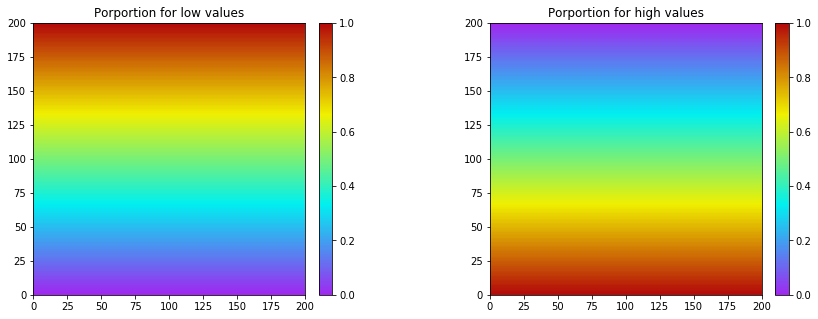

In [24]:
# xg, yg: coordinates of the centers of grid cell
xg = ox + 0.5*sx + sx*np.arange(nx)
yg = oy + 0.5*sy + sy*np.arange(ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define proportion maps for each class
p0 = (yy - np.min(yy))/ (np.max(yy) - np.min(yy))
p1 = 1.0 - p0

local_pdf = np.zeros((nclass, nz, ny, nx))
local_pdf[0,0,:,:] = p0
local_pdf[1,0,:,:] = p1

# Plot these maps
im = img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, v=local_pdf)

plt.subplots(1, 2, figsize=(15,5)) # 1 x 2 sub-plots
plt.subplot(1,2,1)
imgplt.drawImage2D(im, iv=0, vmin=0, vmax=1, title='Porportion for low values')
plt.subplot(1,2,2)
imgplt.drawImage2D(im, iv=1, vmin=0, vmax=1, title='Porportion for high values')

### Define probability constraints (class `dsi.SoftProbability`)

In [25]:
sp = dsi.SoftProbability(
    probabilityConstraintUsage=2,   # local probability constraints
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    localPdfSupportRadius=12.,      # support radius
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(dsi.SoftProbability))
    deactivationDistance=4.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=0.001)        # acceptation threshold

### Fill the input structure for deesse and launch deesse

In [26]:
nreal = 1
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType=1,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.5,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

********************************************************************************
DEESSE VERSION 3.1 / BUILD NUMBER 20190307
********************************************************************************
DONE


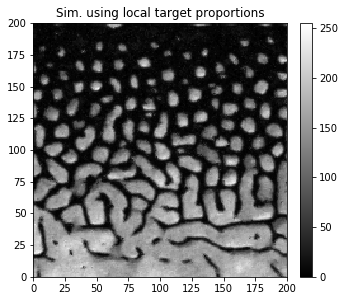

In [27]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
imgplt.drawImage2D(sim[0], cmap=ccol.cmapB2W,
                   title='Sim. using local target proportions')